In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Disable LaTeX rendering so we can use mathtext and Unicode safely
mpl.rcParams['text.usetex'] = False

# Variable Hyperparameters
num_qubits_list = [4, 8]
r_list = [0.0, 0.5, 1.0]
var_ansatz_list = ["QCNN_not_shared", "QCNN_shared", "SEL"]
var_anstaz_label_list = ["QCNN\n (not shared)", "QCNN\n(shared)", "SEL"]
num_layers_list = [1, 3, 5, 7, 9]
num_classes = 4
max_steps = 5000
learning_rate = 0.001
convergence_interval = 300

# Load data for a specific experiment path
def load_data(PATH):
    return (
        np.load(PATH + 'generalization_gap.npy'),
        np.load(PATH + 'test_acc.npy'),
        np.load(PATH + 'mu_marg_Q1.npy'),
        np.load(PATH + 'mu_marg_Q2.npy'),
        np.load(PATH + 'mu_marg_mean.npy'),
        np.load(PATH + 'mu_param.npy'),
        np.load(PATH + 'mu_param_eff10.npy'),
        np.load(PATH + 'mu_param_eff100.npy')
    )

# Fetch data for a single experiment
def get_data_(num_qubits, r, var_ansatz, num_layers, exp_index):
    PATH = f'../../results_TFIM/2C/{r}R/8Q/{var_ansatz}/{num_layers}L_5000MS_Full BatchBS_0.001LR_300conv/20S/{exp_index}E/'
    data = load_data(PATH)
    return np.array(data)

# Apply transformations to data
def reciprocal_transform(x):
    return 1 / x

def apply_transformation(data, transforms):
    return [transform(datum) for datum, transform in zip(data, transforms)]

# Get data across varying x_axis parameter
def get_data(x_axis, num_qubits, var_ansatz, r, num_layers, exp_index):
    data_lists = [[] for _ in range(8)]
    
    transforms = [
        lambda x: x, lambda x: x, reciprocal_transform, reciprocal_transform,
        reciprocal_transform, np.sqrt, np.sqrt, np.sqrt
    ]

    param_map = {
        "num_layers": num_layers_list,
        "r": r_list,
        "var_ansatz": var_ansatz_list
    }
    
    for param_value in param_map[x_axis]:
        if x_axis == "num_layers":
            num_layers = param_value
        elif x_axis == "r":
            r = param_value
        elif x_axis == "var_ansatz":
            var_ansatz = param_value

        data = get_data_(num_qubits, r, var_ansatz, num_layers, exp_index)
        transformed_data = apply_transformation(data, transforms)
        for lst, datum in zip(data_lists, transformed_data):
            lst.append(datum)

    return np.array([np.array(lst) for lst in data_lists])

# Y-axis mapping
data_mapping = {
    "generalization gap": 0,
    "test accuracy": 1,
    "margin (Q1)": 2,
    "margin (Q2)": 3,
    "margin (mean)": 4,
    "params": 5,
    "effective params (0.1)": 6,
    "effective params (0.01)": 7
}

# Label mapping
label_latex_map = {
    "generalization gap": "gen. gap",
    "test accuracy": "Test Accuracy",
    "margin (Q1)": "margin(Q1)$^{-1}$",
    "margin (Q2)": "margin(Q2)$^{-1}$",
    "margin (mean)": "margin(mean)$^{-1}$",
    "params": r"$\sqrt{\mathrm{params}}$",
    "effective params (0.1)": r"$\sqrt{\mathrm{eff.\ params}\ (10^{-1})}$",
    "effective params (0.01)": r"$\sqrt{\mathrm{eff.\ params}\ (10^{-2})}$"
}

def getplots_single(x_axis, y_axis1, y_axis2, y_axis3, y_axis4, y_axis5, num_qubits, var_ansatz, r, num_layers, exp_index=0):
    x_axis_label_map = {
        "num_layers": "Number of Layers",
        "r": "Percentage of Randomized Labels",
        "var_ansatz": "Variational Ansatz"
    }

    x_ticks_map = {
        "QCNN_not_shared": "QCNN",
        "QCNN_shared": "QCNN (param shared)"
    }

    fig, ax_left = plt.subplots(figsize=(9, 6))
    plt.rcParams.update({'font.size': 14}) 

    ax_right1 = ax_left.twinx()
    ax_right2 = ax_left.twinx()

    # Dynamic offset for the second right axis
    offset_val = 70 if x_axis == "num_layers" else 50
    ax_right2.spines['right'].set_position(('outward', offset_val))

    data = get_data(x_axis, num_qubits, var_ansatz, r, num_layers, exp_index)

    param_map = {
        "num_layers": num_layers_list,
        "r": r_list,
        "var_ansatz": var_ansatz_list
    }
    x_data = param_map[x_axis]
    x_labels = [x_ticks_map.get(label, label) for label in x_data]
    x_range = range(len(x_labels))

    y1_list = np.maximum(data[data_mapping[y_axis1]], 0)
    y2_list = np.round(data[data_mapping[y_axis2]], 2)
    y3_list = data[data_mapping[y_axis3]]
    y4_list = data[data_mapping[y_axis4]]
    y5_list = data[data_mapping[y_axis5]]

    # Define colors and markers for the three lines sharing ax_right2
    colors = ['green', 'blue', 'orange']
    markers = ['^', 's', 'D']
    linestyles = [':', '-.', '--']

    line1, = ax_left.plot(x_range, y1_list, label=y_axis1, marker='x', markersize=7, color='purple', linestyle='-')
    line2, = ax_right1.plot(x_range, y2_list, label=y_axis2, marker='o', markersize=7, color='red', linestyle='--')
    
    # Plot the three lines sharing ax_right2
    line3, = ax_right2.plot(x_range, y3_list, label=y_axis3, marker=markers[0], markersize=7, color=colors[0], linestyle=linestyles[0])
    line4, = ax_right2.plot(x_range, y4_list, label=y_axis4, marker=markers[1], markersize=7, color=colors[1], linestyle=linestyles[1])
    line5, = ax_right2.plot(x_range, y5_list, label=y_axis5, marker=markers[2], markersize=7, color=colors[2], linestyle=linestyles[2])

    # Conditionally set axis labels
    if x_axis == "num_layers":
        ax_left.set_ylabel(label_latex_map[y_axis1], color='purple')
    else:
        ax_left.set_ylabel("")


    if x_axis == "num_layers":
        ax_right1.set_ylabel(label_latex_map[y_axis2], color='red')
        ax_right2.set_ylabel(label_latex_map[y_axis3], color='green')
    else:
        ax_right1.set_ylabel("")
        ax_right2.set_ylabel("")

    # Conditionally show legend
    if x_axis == "num_layers":
        lines = [line1, line2, line3, line4, line5]
        labels = [label_latex_map[line.get_label()] for line in lines]
        ax_left.legend(lines, labels, loc='upper left', prop={'size': 12})

    # X-axis setup
    ax_left.set_xlabel(x_axis_label_map.get(x_axis, x_axis))
    ax_left.set_xticks(x_range)
    ax_left.set_xticklabels(x_labels)

    plt.tight_layout()
    plt.savefig(f'TFIM_{x_axis}_{y_axis2}_{y_axis3}_{y_axis4}_{y_axis5}_{var_ansatz}_{r}_{num_layers}.pdf', bbox_inches='tight')
    plt.show()

In [23]:
# Example usage
y_axis1 = "margin (Q1)"
y_axis2 = "params"
y_axis3 = "effective params (0.1)"
y_axis4 = "effective params (0.01)"
num_qubits = 8
var_ansatz = "QCNN_not_shared"
r =0.0
num_layers = 9
exp =  3# Single experiment index

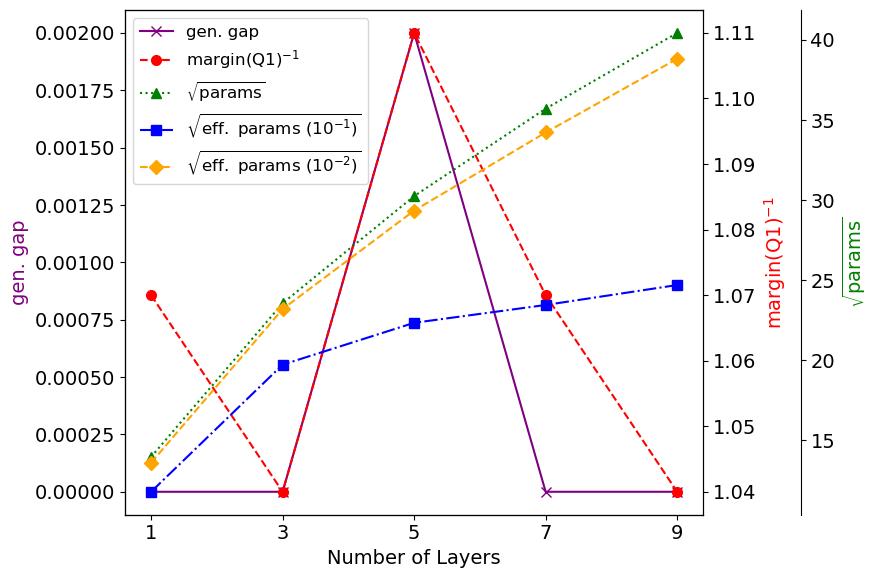

In [24]:
#getplots_average("num_layers", "generalization gap", "margin (Q1)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 1)
getplots_single("num_layers", "generalization gap", y_axis1, y_axis2, y_axis3, y_axis4, num_qubits, var_ansatz, r, num_layers, exp)

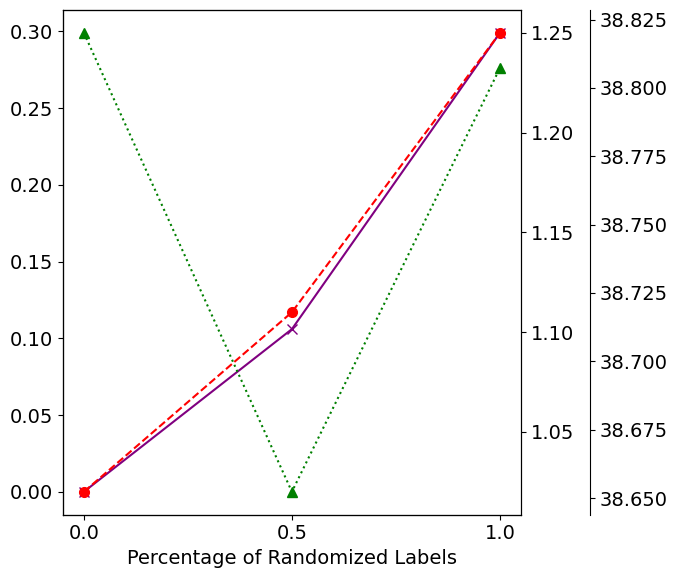

In [32]:
#getplots_average("r", "generalization gap", "margin (mean)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 20)
getplots_single("r", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_68557/1555514095.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / x


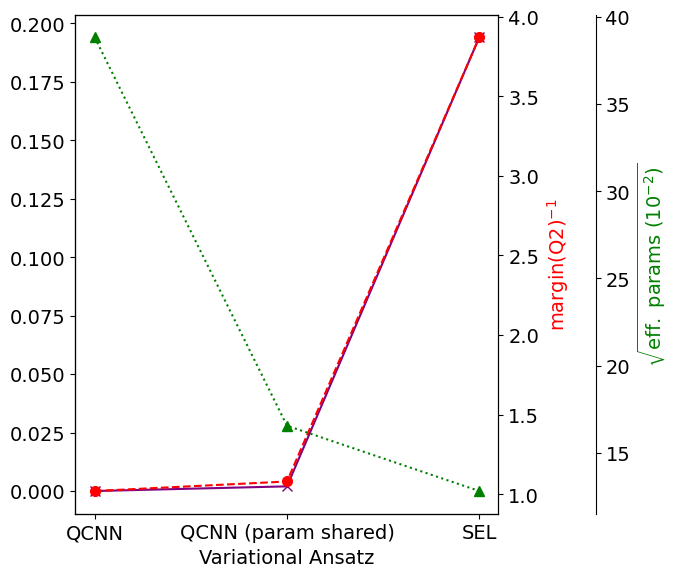

In [33]:
#getplots_average("var_ansatz", "generalization gap", "margin (mean)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 20)
getplots_single("var_ansatz", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)